# Retention estimation for censored data
This intends to calculate the posterio distribution of the alpha and beta paramters from the shifted beta geometric distribution presented by __[Fader and Hardie](http://www.brucehardie.com/papers/021/sbg_2006-05-30.pdf)__.
I took the idea from __[Daniel Wietzenfied's site](http://danielweitzenfeld.github.io/passtheroc/blog/2015/01/19/s-b-g/)__, he's using pymc while I'm trying to use pymc3.

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
from scipy import optimize
import matplotlib.pyplot as plt
import theano.tensor as tt
from theano.tensor import _shared

The following data is the same Fader used in his example:

In [2]:
#example_data = np.array([1000, 869, 743, 653, 593, 551, 517, 491])
example_data = np.array([1000,472,395,362,342,329,320,317,303,294,286,281,278,276,276,269,262,257,254,252,250,252,246,242,238])

In [3]:
def n_lost(data):
    lost = [None]
    for i in range(1, len(data)):
        lost.append(data[i - 1] - data[i])
    return lost

example_data_n_lost = n_lost(example_data)
data = np.asarray((example_data, example_data_n_lost))

In [49]:
def P_T_is_t(active, alpha, beta):
    p = np.array([None, alpha / (alpha + beta)])
    for t in range(2, num_periods):
        pt = ((beta + t - 2) / (alpha + beta + t - 1)) * p[t-1]
        p = np.append(p,pt)
    return p

def survival_function(active, alpha, beta):
    p = P_T_is_t(active, alpha, beta)
    s = np.array([None, 1 - p[1]])
    for t in range(2, num_periods):
        s = np.append(s, s[t-1] - p[t])
    return s

def logpx(value, alpha, beta):

    active = value[0,:]
    lost = value[1,:]
    
    # Those who've churned along the way...
    p = P_T_is_t(active, alpha, beta)
    died = np.multiply(np.log(p[1:]), lost[1:])
    
    # and those still active in last period
    sf = survival_function(active, alpha, beta)
    still_active = np.log(sf[-1]) * active[-1]
    return  sum(died) + still_active

In [50]:
with pm.Model() as model:
    alpha = pm.Uniform('alpha', 0.00001, 1000.0)
    beta = pm.Uniform('beta', 0.00001, 1000.0)
    num_periods = len(example_data)


    retention = pm.DensityDist('retention', logpx, observed={'value':data, 'alpha':alpha, 'beta': beta})
    print_alpha = tt.printing.Print('alpha')(alpha)
    print_beta = tt.printing.Print('beta')(beta)
    trace = pm.sample(10000, step=pm.Metropolis())
    burned_trace = trace[3000:]


alpha __str__ = 500.000005
beta __str__ = 500.000005



100%|██████████████████████████████████| 10000/10000 [00:05<00:00, 1870.24it/s]

In [47]:
print_alpha

Print{message='alpha', attrs=('__str__',), global_fn=<function _print_fn at 0x000001DA992F7840>}.0

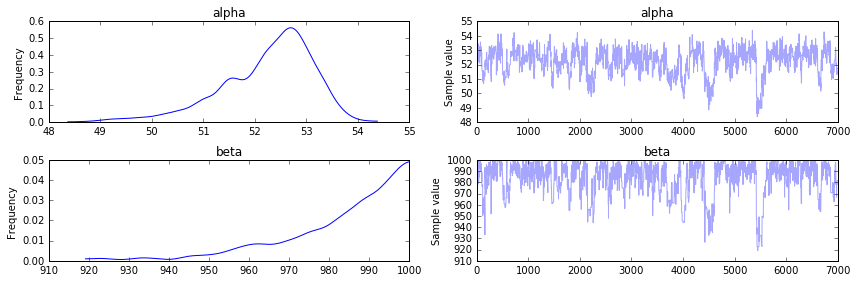

In [48]:
_=pm.traceplot(burned_trace)

In [268]:
burned_trace['alpha'].mean()

84.826351890825137

In [269]:
burned_trace['beta'].mean()

824.43470164695384